<a href="https://colab.research.google.com/github/lromano97/text-mining/blob/main/variable-talks__tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏷️ talks__tags

Como resultado del web scrapping en la página TED, vemos que la variable `talks_tags` de cada charla puede tener múltiples valores (desde 0 tags hasta charlas que tienen 31).

La solución principal a nuestro modelo sería crear modelos que soporten variables target [*multioutput* y *multiclass*](https://scikit-learn.org/stable/modules/multiclass.html), pero entendemos que podría simplificarse su solución a uno multiclass.

La exploración de la variable `talks_tags` en esta notebook pretende ver la viabilidad de simplificarlo en ese sentido.


In [2]:
# activando Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd "/content/gdrive/My Drive/Colab Notebooks/Text Mining/TopicsTED"

/content/gdrive/My Drive/Colab Notebooks/Text Mining/TopicsTED


In [ ]:
! pip install --upgrade gensim
! brew install wget
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
! gzip -d GoogleNews-vectors-negative300.bin.gz

In [ ]:
# preparación del entorno

# librerías de uso común
import pandas as pd
import numpy as np
import ast
import re

# visualización
import seaborn as sns
import matplotlib.pyplot as plt

# librerías y dependencias para npl
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

# affinity propagation clustering
from sklearn.cluster import AffinityPropagation

# pca & Word2Vec
from gensim import models
from gensim.models import KeyedVectors
embeddings = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary = True)

# sin warnings
import warnings
warnings.filterwarnings('ignore')

# impresiones compactas
import pprint
pp = pprint.PrettyPrinter(compact=True)

In [6]:
# importando base de datos y extrayendo variables de interés
datos = pd.read_csv('TED_Talk.csv', index_col='talk__id')
datos = datos[['talks__tags', 'number_of__tags']]

# convirtiendo la variable 'talks__tags' en una lista
datos['talks__tags'] = datos['talks__tags'].apply(lambda x: ast.literal_eval(x))

## Exploratorio de la variable talks_tags

Las charlas TED tiene múltiples tags, algunas de ella 0 y algunas pocas hasta 31 tags.

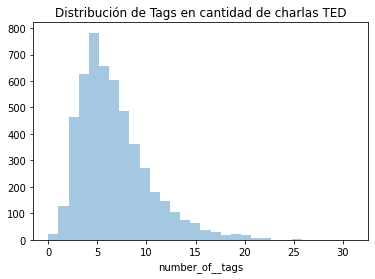

In [7]:
#datos['number_of__tags'].value_counts()
sns.distplot(datos["number_of__tags"]
             , hist=True, kde=False, bins=30).set_title('Distribución de Tags en cantidad de charlas TED')
sns.set(rc={'figure.figsize':(12,8)})

El dataset contiene 347 labels, algunos de ellos con presencia en solo una o dos de las más de 5.000 charlas TED.

In [8]:
# generación de data set para análisis de tags.
s = datos.apply(lambda x: pd.Series(x['talks__tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'temas'
temas_df = datos.drop('talks__tags', axis=1).join(s)
temas_df = temas_df.dropna()
temas_df = temas_df[['temas']]

# conteo de valores únicos en la variable theme
temas_df['temas'].value_counts()

science          1164
technology       1159
culture           783
TED-Ed            748
society           679
                 ... 
pain                2
microbes            2
Hinduism            1
crowdsourcing       1
goal-setting        1
Name: temas, Length: 347, dtype: int64

In [9]:
#Verificamos el balance de clases
pop_temas = pd.DataFrame(temas_df['temas'].value_counts()).reset_index()
pop_temas.columns = ['temas', 'talks']

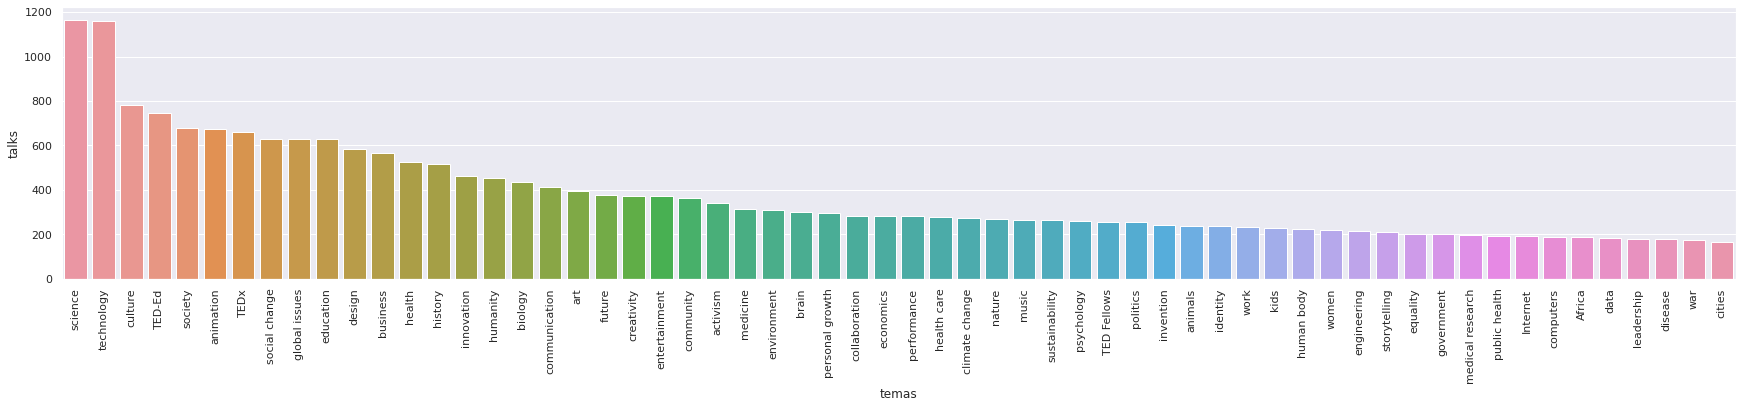

In [10]:
plt.figure(figsize=(30,5))
sns.barplot(x='temas', y='talks', data=pop_temas.head(60))
plt.xticks(rotation=90)
plt.show()

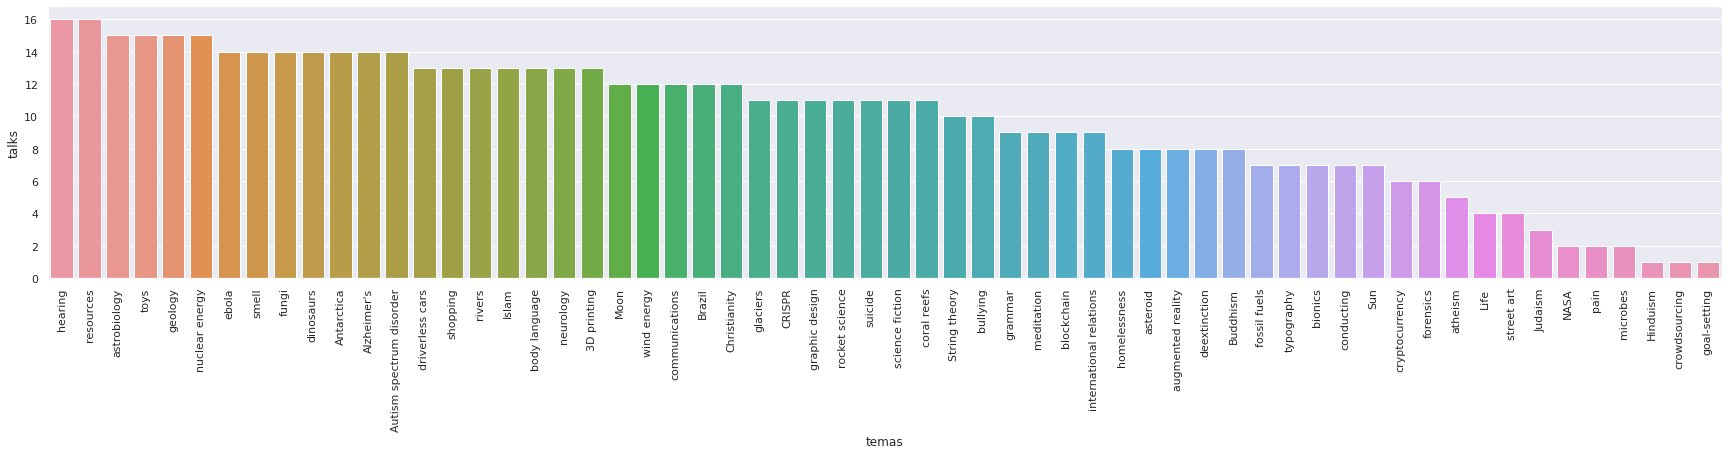

In [11]:
plt.figure(figsize=(30,5))
sns.barplot(x='temas', y='talks', data=pop_temas.tail(60))
plt.xticks(rotation=90)
plt.show()

## Preprocesamiento de la variable talks__tags

Para poder reducir la dimensionalidad de la variable `talks__tags`, necesitamos aplicar los siguientes pasos de preprocesamiento:

- [ ] Eliminar los espacios (3D printing -> 3d_printing): el uso de synsets no reconoce las ngrams separadas por espacios, pero sí por letras 
- [ ] Colocar todas las palabras en minúscula: en particular por ordenamiento
- [ ] Eliminar algunos tags: como el caso de los referidos a TED*** o que no tengan un Synset asociado

In [12]:
# Creando una lista con los talks__tags
temas = list(set(temas_df['temas']))

# Eliminando los tags TED*
ted = re.compile("TED*.")
tedlist = list(filter(ted.match, temas))
temas = [word for word in temas if word not in tedlist]

# Colocando todo el texto en minúscula
for i in range(len(temas)):
    temas[i] = temas[i].lower()
 
# Remplazando espacios por el caracter _
temas = [sub.replace(' ', '_') for sub in temas]

# Ordenando la lista
temas.sort()
pp.pprint(temas)

['3d_printing', 'activism', 'addiction', 'africa', 'aging', 'agriculture', 'ai',
 'aids', 'algorithm', 'aliens', "alzheimer's", 'ancient_world', 'animals',
 'animation', 'antarctica', 'anthropocene', 'anthropology', 'archaeology',
 'architecture', 'art', 'asia', 'asteroid', 'astrobiology', 'astronomy',
 'atheism', 'audacious_project', 'augmented_reality',
 'autism_spectrum_disorder', 'bacteria', 'beauty', 'bees',
 'behavioral_economics', 'best_of_the_web', 'big_bang', 'biodiversity',
 'bioethics', 'biology', 'biomimicry', 'bionics', 'biosphere', 'biotech',
 'birds', 'blindness', 'blockchain', 'body_language', 'books', 'botany',
 'brain', 'brazil', 'buddhism', 'bullying', 'business', 'cancer', 'capitalism',
 'chemistry', 'china', 'christianity', 'cities', 'climate_change', 'code',
 'cognitive_science', 'collaboration', 'comedy', 'communication',
 'communications', 'community', 'compassion', 'computers', 'conducting',
 'consciousness', 'conservation', 'consumerism', 'coral_reefs', 'coron

# Reducción de la dimensionalidad

## Affinity Propagation Clustering Algorithm

Usando el algoritmo *Affinity Propagation Clustering Algorithm* de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html) vamos a intentar reducir la dimensionalidad de nuestras 350 tags.

Básicamente se va a utilizar los synsets de cada palabra. Es importante en este punto identificar y eliminar o remplazar las palabras que no tengan synset dado que la posterior aplicación del modelo generará error.



In [14]:
sin_synset = []
for tema in temas:
    try:
        print(tema, wn.synsets(tema)[0])
    except:
        sin_synset.append(tema)
        print(tema, 'SIN SYNSET')

3d_printing SIN SYNSET
activism Synset('activism.n.01')
addiction Synset('addiction.n.01')
africa Synset('africa.n.01')
aging Synset('ripening.n.02')
agriculture Synset('agribusiness.n.01')
ai Synset('army_intelligence.n.01')
aids Synset('aids.n.01')
algorithm Synset('algorithm.n.01')
aliens Synset('foreigner.n.01')
alzheimer's Synset('alzheimer's_disease.n.01')
ancient_world SIN SYNSET
animals Synset('animal.n.01')
animation Synset('animation.n.01')
antarctica Synset('antarctica.n.01')
anthropocene SIN SYNSET
anthropology Synset('anthropology.n.01')
archaeology Synset('archeology.n.01')
architecture Synset('architecture.n.01')
art Synset('art.n.01')
asia Synset('asia.n.01')
asteroid Synset('asteroid.n.01')
astrobiology Synset('exobiology.n.01')
astronomy Synset('astronomy.n.01')
atheism Synset('atheism.n.01')
audacious_project SIN SYNSET
augmented_reality SIN SYNSET
autism_spectrum_disorder SIN SYNSET
bacteria Synset('bacteria.n.01')
beauty Synset('beauty.n.01')
bees Synset('bee.n.01'

In [15]:
pp.pprint(sin_synset)

['3d_printing', 'ancient_world', 'anthropocene', 'audacious_project',
 'augmented_reality', 'autism_spectrum_disorder', 'behavioral_economics',
 'best_of_the_web', 'biomimicry', 'blockchain', 'coronavirus', 'crispr',
 'crowdsourcing', 'cryptocurrency', 'cyber_security', 'decision-making',
 'deextinction', 'driverless_cars', 'global_issues', 'goal-setting',
 'indigenous_peoples', 'industrial_design', 'international_development',
 'international_relations', 'justice_system', 'lgbtqia+', 'machine_learning',
 'marine_biology', 'medical_imaging', 'medical_research', 'mission_blue',
 'natural_disaster', 'online_privacy', 'personal_growth', 'product_design',
 'public_health', 'public_space', 'renewable_energy', 'rocket_science',
 'sexual_violence', 'social_change', 'social_media', 'storytelling',
 'street_art', 'synthetic_biology', 'ux_design', 'wind_energy',
 'women_in_business', 'work-life_balance']


In [16]:
temas_apc = [word for word in temas if word not in sin_synset]
pp.pprint(temas_apc)

['activism', 'addiction', 'africa', 'aging', 'agriculture', 'ai', 'aids',
 'algorithm', 'aliens', "alzheimer's", 'animals', 'animation', 'antarctica',
 'anthropology', 'archaeology', 'architecture', 'art', 'asia', 'asteroid',
 'astrobiology', 'astronomy', 'atheism', 'bacteria', 'beauty', 'bees',
 'big_bang', 'biodiversity', 'bioethics', 'biology', 'bionics', 'biosphere',
 'biotech', 'birds', 'blindness', 'body_language', 'books', 'botany', 'brain',
 'brazil', 'buddhism', 'bullying', 'business', 'cancer', 'capitalism',
 'chemistry', 'china', 'christianity', 'cities', 'climate_change', 'code',
 'cognitive_science', 'collaboration', 'comedy', 'communication',
 'communications', 'community', 'compassion', 'computers', 'conducting',
 'consciousness', 'conservation', 'consumerism', 'coral_reefs', 'corruption',
 'countdown', 'creativity', 'crime', 'culture', 'curiosity', 'dance',
 'dark_matter', 'data', 'death', 'demo', 'democracy', 'depression', 'design',
 'dinosaurs', 'disability', 'discove

**remplazando palabras con synsets que generar confusión**

In [17]:
temas_apc.remove('ai')
temas_apc.append('artificial_intelligence')
temas_apc.sort()
pp.pprint(temas_apc)

['activism', 'addiction', 'africa', 'aging', 'agriculture', 'aids', 'algorithm',
 'aliens', "alzheimer's", 'animals', 'animation', 'antarctica', 'anthropology',
 'archaeology', 'architecture', 'art', 'artificial_intelligence', 'asia',
 'asteroid', 'astrobiology', 'astronomy', 'atheism', 'bacteria', 'beauty',
 'bees', 'big_bang', 'biodiversity', 'bioethics', 'biology', 'bionics',
 'biosphere', 'biotech', 'birds', 'blindness', 'body_language', 'books',
 'botany', 'brain', 'brazil', 'buddhism', 'bullying', 'business', 'cancer',
 'capitalism', 'chemistry', 'china', 'christianity', 'cities', 'climate_change',
 'code', 'cognitive_science', 'collaboration', 'comedy', 'communication',
 'communications', 'community', 'compassion', 'computers', 'conducting',
 'consciousness', 'conservation', 'consumerism', 'coral_reefs', 'corruption',
 'countdown', 'creativity', 'crime', 'culture', 'curiosity', 'dance',
 'dark_matter', 'data', 'death', 'demo', 'democracy', 'depression', 'design',
 'dinosaurs', '

### Wu-Palmer Similarity

Usando la distancia **Wu-Palmer Similarity** y cambiando el parámetro `affinity`.

In [18]:
# Aplicando el modelo APC con la distancia Wu-Palmer Similarity

words_apc = np.asarray(temas_apc) # So that indexing with a list will work
similarity = np.array([[wn.synsets(w1)[0].wup_similarity(wn.synsets(w2)[0]) for w1 in words_apc] for w2 in words_apc])
similarity[similarity == None] = 0

affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words_apc[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words_apc[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *addiction:* addiction, homelessness, pollution, poverty, pregnancy, ptsd, sleep, vulnerability
 - *aging:* aging, climate_change, evolution, sex
 - *animals:* aliens, animals, bacteria, bees, birds, coral_reefs, dinosaurs, drones, entrepreneur, fish, insects, kids, microbes, refugees, trees, virus, women, youth
 - *architecture:* architecture, library, plants, prison, theater
 - *art:* art, books, dance, film, innovation, maps, museums, painting, toys
 - *asia:* africa, antarctica, asia, europe, south_america
 - *biodiversity:* biodiversity, diversity
 - *biology:* astrobiology, biology, biotech, genetics, medicine, microbiology, neurology, neuroscience, prosthetics, surgery
 - *consciousness:* alzheimer's, consciousness, curiosity, depression, mental_health, self
 - *creativity:* atheism, consumerism, creativity, democracy, ethics, invention, meditation, motivation, pain, smell
 - *data:* botany, capitalism, data, flight, fungi, gender, law, primates, solar_system
 - *dna:* dna, s

In [19]:
affprop = AffinityPropagation(affinity="euclidean", damping=0.5)
affprop.fit(similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words_apc[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words_apc[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *africa:* africa, antarctica, asia, coral_reefs, europe, glaciers, south_america
 - *aids:* aids, alzheimer's, blindness, cancer, disability, disease, ebola, health, illness, ptsd
 - *bacteria:* aliens, animals, bacteria, bees, birds, dinosaurs, drones, entrepreneur, fish, insects, kids, microbes, refugees, trees, virus, women, youth
 - *cities:* biosphere, brazil, china, cities, egypt, india, middle_east, united_states
 - *code:* body_language, code, comedy, demo, graphic_design, humor, language, literature, music, poetry, science_fiction, software
 - *community:* botany, buddhism, business, capitalism, community, culture, data, family, flight, fungi, gender, government, hinduism, islam, judaism, law, military, nasa, primates, society, solar_system
 - *electricity:* climate_change, electricity, energy, nuclear_energy, sex, solar_energy, weather
 - *hearing:* agriculture, big_bang, collaboration, communication, conducting, conservation, death, discovery, ethics, exploration, farming

### Path similarity

In [20]:
# Aplicando el modelo APC con la distancia Path Similarity

similarity = np.array([[wn.synsets(w1)[0].path_similarity(wn.synsets(w2)[0]) for w1 in words_apc] for w2 in words_apc])
similarity[similarity == None] = 0

affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words_apc[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words_apc[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *addiction:* addiction, homelessness, pollution, poverty, pregnancy, ptsd, sleep, vulnerability
 - *animation:* animation, life, potential
 - *architecture:* architecture, library, plants, prison, theater
 - *art:* art, dance, innovation, maps, museums, painting, toys
 - *asia:* africa, antarctica, asia, europe, south_america
 - *bees:* bees, drones, insects
 - *biodiversity:* biodiversity, diversity
 - *biology:* astrobiology, biology, biotech, genetics, microbiology, neuroscience
 - *birds:* animals, birds, dinosaurs, fish
 - *blindness:* blindness, disability
 - *botany:* botany, capitalism, data, fungi, gender, law, primates, solar_system
 - *buddhism:* buddhism, hinduism, judaism
 - *consciousness:* alzheimer's, consciousness, curiosity, depression, mental_health, self
 - *creativity:* atheism, creativity, invention, pain, smell
 - *discovery:* collaboration, communication, conducting, discovery, hearing, interview, protest, public_speaking, shopping, terrorism, violence, war
 

### Leacock Chordorow (LCH) similarity

In [21]:
# Aplicando el modelo APC con la distancia Leacock Chordorow (LCH) similarity

similarity = np.array([[wn.synsets(w1)[0].lch_similarity(wn.synsets(w2)[0]) for w1 in words_apc] for w2 in words_apc])
similarity[similarity == None] = 0

affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words_apc[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words_apc[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

WordNetError: ignored

# PCA Dimensionality Reduction and Word Vectors

Se consideran las siguientes notebooks / páginas:
* [Neurotic Networking](https://necromuralist.github.io/Neurotic-Networking/posts/nlp/pca-dimensionality-reduction-and-word-vectors/).
* [Towards Data Science](https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354).
* [Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html).

In [22]:
def compute_pca(X: np.ndarray, n_components: int=2) -> np.ndarray:
    """Calculate the principal components for X

    Args:
       X: of dimension (m,n) where each row corresponds to a word vector
       n_components: Number of components you want to keep.

    Return:
       X_reduced: data transformed in 2 dims/columns + regenerated original data
    """
    # you need to set axis to 0 or it will calculate the mean of the entire matrix instead of one per row
    X_demeaned = X - X.mean(axis=0)

    # calculate the covariance matrix
    # the default numpy.cov assumes the rows are variables, not columns so set rowvar to False
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)

    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = list(reversed(idx_sorted))

    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    # We're only sorting the columns so remember to get all the rows in the slice
    eigen_vecs_sorted = eigen_vecs[:, idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    # once again, make sure to get all the rows and only slice the columns
    eigen_vecs_subset = eigen_vecs_sorted[:, :n_components]

    # transform the data by multiplying the transpose of the eigenvectors 
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.dot(eigen_vecs_subset.T, X_demeaned.T).T
    return X_reduced

In [23]:
words_pca = temas.copy()

In [28]:
sin_word2vec = []
for word in words_pca:
    try:
        embeddings[word]
    except KeyError:
        words_pca.remove(word)
        sin_word2vec.append(word)

In [29]:
subset = np.array([embeddings[word] for word in words_pca])
reduced = compute_pca(subset)
reduced = pd.DataFrame(reduced, columns="X Y".split())
reduced["Word"] = words_pca

In [30]:
reduced.head()

,X,Y,Word
0,-0.582826,0.507314,activism
1,-0.713544,-0.461153,addiction
2,-0.471775,-0.907877,africa
3,-0.245632,-0.404840,aging
4,0.626456,0.092504,agriculture


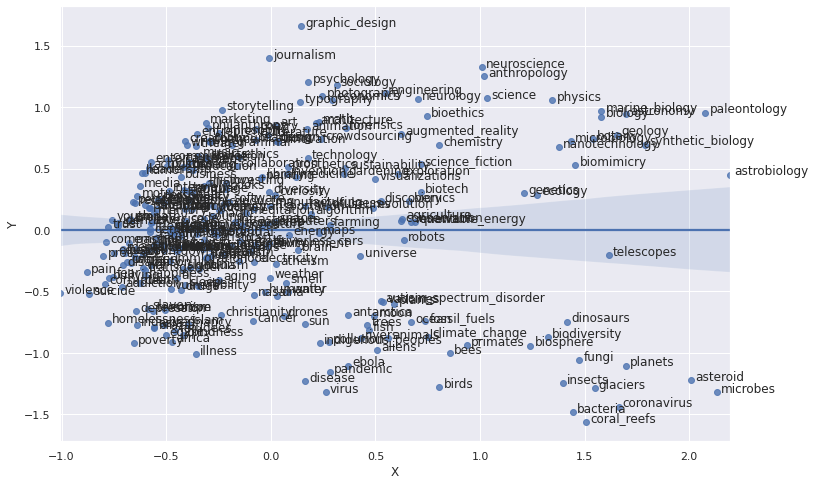

In [31]:
sns.regplot(x=reduced["X"], y=reduced["Y"])

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(reduced.X, reduced.Y, reduced.Word, plt.gca())
#plt.figure(figsize=(10, 6))

# Código de exploración


## hiperónimos e hipónimos

In [32]:
# synsets asociados a una palabra
wn.synsets('ai')

[Synset('army_intelligence.n.01'),
 Synset('artificial_intelligence.n.01'),
 Synset('three-toed_sloth.n.01'),
 Synset('artificial_insemination.n.01')]

In [33]:
# distancia wup entre dos palabras
cb = wn.synsets('astronomy')[0]
ib = wn.synsets('sun')[4]
cb.wup_similarity(ib)

# 0-0: 10.5%
# 0-1:  8.7%
# 0-2: 11.1%
# 0-3: 10.5%
# 0-4: 20.0%
# 0-5: None
# 0-6: None
# 0-7: Error, naturalmente

0.2

In [34]:
palabra_synset = wn.synsets('planets')[0] #ptsd
print('-- Hiperónimos --')
print(palabra_synset.hypernyms())
print('-- Hipónimos --')
print(palabra_synset.hypernyms()[0].hyponyms())
print('-- La raiz --')
palabra_synset.hypernym_paths()

-- Hiperónimos --
[Synset('celestial_body.n.01')]
-- Hipónimos --
[Synset('minor_planet.n.01'), Synset('planet.n.01'), Synset('planet.n.03'), Synset('planetesimal.n.01'), Synset('primary.n.03'), Synset('quasar.n.01'), Synset('satellite.n.03'), Synset('star.n.01'), Synset('star.n.03')]
-- La raiz --


[[Synset('entity.n.01'),
  Synset('physical_entity.n.01'),
  Synset('object.n.01'),
  Synset('whole.n.02'),
  Synset('natural_object.n.01'),
  Synset('celestial_body.n.01'),
  Synset('planet.n.01')]]

In [35]:
palabra_synset = wn.synsets('universe')[0]  #depression
print('-- Hiperónimos --')
print(palabra_synset.hypernyms())
print('-- Hipónimos --')
print(palabra_synset.hypernyms()[0].hyponyms())
print('-- La raiz --')
palabra_synset.hypernym_paths()

-- Hiperónimos --
[Synset('natural_object.n.01')]
-- Hipónimos --
[Synset('asterism.n.02'), Synset('black_body.n.01'), Synset('body.n.01'), Synset('body.n.03'), Synset('body.n.04'), Synset('carpet.n.02'), Synset('celestial_body.n.01'), Synset('cocoon.n.01'), Synset('consolidation.n.03'), Synset('constellation.n.02'), Synset('covering.n.01'), Synset('extraterrestrial_object.n.01'), Synset('mechanism.n.03'), Synset('nest.n.01'), Synset('plant_part.n.01'), Synset('radiator.n.01'), Synset('rock.n.01'), Synset('sample.n.03'), Synset('tangle.n.01'), Synset('universe.n.01')]
-- La raiz --


[[Synset('entity.n.01'),
  Synset('physical_entity.n.01'),
  Synset('object.n.01'),
  Synset('whole.n.02'),
  Synset('natural_object.n.01'),
  Synset('universe.n.01')]]

## sinónimos y antónimos

In [36]:
synonyms = []
antonyms = []
  
for syn in wn.synsets("atomic_energy"):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())
        if lemma.antonyms():
            antonyms.append(lemma.antonyms()[0].name())
  
pp.pprint(set(synonyms))
pp.pprint(set(antonyms))

{'nuclear_energy', 'atomic_energy'}
set()


## word2vec



In [37]:
embeddings['king']

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [38]:
# hay palabras que no le son familiares.
# Una alternativa sería trabajar sobre el modelo 'FastText'
try:
    vec_word = embeddings['sexual violence']
except KeyError:
    print("--Esa palabra no aprece en el modelo--")

--Esa palabra no aprece en el modelo--


In [39]:
# similitud entre palabras
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, embeddings.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


In [40]:
# imprimir las cinco palabras más similares a 'car' o 'minivan'
print(embeddings.most_similar(positive=['car', 'minivan'], topn=5))

[('SUV', 0.8532192707061768), ('vehicle', 0.8175783753395081), ('pickup_truck', 0.7763688564300537), ('Jeep', 0.7567334175109863), ('Ford_Explorer', 0.7565720081329346)]


In [41]:
# cuál de las siguientes no pertenece a la secuencia
print(embeddings.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


# Resumen

En esta notebook tendríamos 3 modelos y un 4o por corregir:
    
    1. Un algoritmo de clustering con dos medidas diferentes
    2. Un tercer algoritmo con la medida LCH con error por algún synset
    3. Uno de PCA


**Pendientes - Posibles Caminos**

1. Estuve viendo varias palabras en la sección de hiperónimos e hipónimos y no vi claro cómo decirle a una palabra llegue hasta tal nivel del arbol. Si tomamos como ejemplo Universo y Planetas, en uno habría que subir un nivel y en otro dos para llegar a `natural_object` que sería en concepto menos abstracto.
2. Faltaría recorrer el camino de remplazo de sinónimos por antónimos, y ver si con esto la clasificación es más eficiente.
3. Con PCA se podría explorar la agrupación por rango de coordenadas
4. Corregir los synsets para el algoritmo de medida de LCH
5. Lo más importante 😔, terminar de depurar la variable `talks__tags` con el camino que se decida.


**Rarezas**

1. No sé por qué la línea de `sin_word2vec` la tengo que correr tres veces, porque a la primera no elimina todas las palabras que no están en el modelo. 